# MBTI Prediction - Strategy 2
In this notebook, we will train a classification model for each category and not only one to directly predict the full MBTI type.

## Libraries

In [1]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

## Data import

In [2]:
df = pd.read_csv('../mbti_data.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Data preprocessing

First, we prepare our targets. We will have one classifier to predict the "target_ie" value, one for "target_sn", one for "target_tf" and one for "target_jp".

In [3]:
df['target_ie'] = df['type'].apply(lambda row: row[0])
df['target_sn'] = df['type'].apply(lambda row: row[1])
df['target_tf'] = df['type'].apply(lambda row: row[2])
df['target_jp'] = df['type'].apply(lambda row: row[3])
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


Let's see the distribition of the new variables created.

In [4]:
ie_dist = df['target_ie'].value_counts().rename_axis('types').reset_index(name='counts')
sn_dist = df['target_sn'].value_counts().rename_axis('types').reset_index(name='counts')
tf_dist = df['target_tf'].value_counts().rename_axis('types').reset_index(name='counts')
jp_dist = df['target_jp'].value_counts().rename_axis('types').reset_index(name='counts')

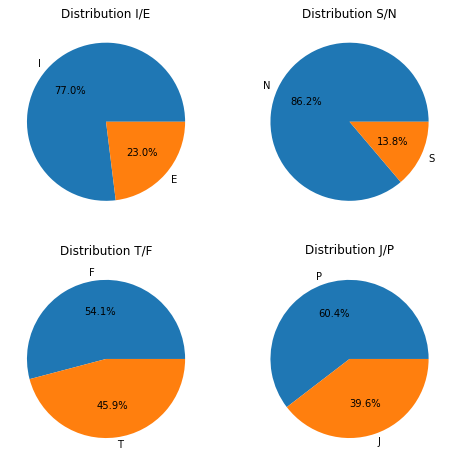

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].pie(ie_dist['counts'], labels=ie_dist['types'], autopct='%1.1f%%')
axs[0, 0].set_title('Distribution I/E')
axs[0, 1].pie(sn_dist['counts'], labels=sn_dist['types'], autopct='%1.1f%%')
axs[0, 1].set_title('Distribution S/N')
axs[1, 0].pie(tf_dist['counts'], labels=tf_dist['types'], autopct='%1.1f%%')
axs[1, 0].set_title('Distribution T/F')
axs[1, 1].pie(jp_dist['counts'], labels=jp_dist['types'], autopct='%1.1f%%')
axs[1, 1].set_title('Distribution J/P')
plt.show()

F1-score

Let's preprocess the data.

In [6]:
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

def preprocessing(text, stemming_on=False, stop_words=stop_words, porter_stemmer=porter_stemmer):
    text = text.lower()                                          # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)                  # Noise removal (regex to remove punctuations)
    text = text.strip()                                          # Noise removal (extra spaces)
    words = text.split()                                         # Split sentence into list of words
    words = [w for w in words if not w in stop_words]            # Stopwords removal
    if(stemming_on):
        words = [porter_stemmer.stem(word) for word in words]    # Replace the word by its stem
    text = ' '.join(words)                                       # Transform list of words to str
    return text

In [7]:
df['posts_preproc'] = df['posts'].apply(lambda row: preprocessing(row, stemming_on=True))

In [8]:
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp,posts_preproc
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,http www youtub com watch v qsxhcwe3krw http 4...
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,find lack post alarm sex bore posit often exam...
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,good one http www youtub com watch v fhigbolff...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,dear intp enjoy convers day esoter gab natur u...
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,fire anoth silli misconcept approach logic go ...


## Vectorization

In [9]:
c_vectorizer = CountVectorizer()
ti_vectorizer = TfidfVectorizer()

In [10]:
c_X = c_vectorizer.fit_transform(df['posts_preproc'])
ti_X = ti_vectorizer.fit_transform(df['posts_preproc'])

## Prediction

 ### Target I/E

In [11]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_ie'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_ie'], test_size=0.2, random_state=14)

**Configuration 1:** CountVectorizer + LinearSVC

In [12]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

              precision    recall  f1-score   support

           E       0.58      0.58      0.58       379
           I       0.88      0.88      0.88      1356

    accuracy                           0.82      1735
   macro avg       0.73      0.73      0.73      1735
weighted avg       0.82      0.82      0.82      1735



c:\users\anthony\documents\machine-learning\mbti-prediction\dev-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


**Configuration 2:** TfidfVectorizer + LinearSVC

In [13]:
ti_clf = LinearSVC(random_state=14)
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred))

              precision    recall  f1-score   support

           E       0.75      0.56      0.64       379
           I       0.88      0.95      0.92      1356

    accuracy                           0.86      1735
   macro avg       0.82      0.75      0.78      1735
weighted avg       0.86      0.86      0.86      1735



 ### Target S/N

In [14]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_sn'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_sn'], test_size=0.2, random_state=14)

**Configuration 1:** CountVectorizer + LinearSVC

In [15]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

              precision    recall  f1-score   support

           N       0.94      0.93      0.93      1516
           S       0.54      0.55      0.55       219

    accuracy                           0.88      1735
   macro avg       0.74      0.74      0.74      1735
weighted avg       0.89      0.88      0.89      1735



**Configuration 2:** TfidfVectorizer + LinearSVC

In [16]:
ti_clf = LinearSVC(random_state=14)
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred))

              precision    recall  f1-score   support

           N       0.93      0.98      0.95      1516
           S       0.79      0.45      0.58       219

    accuracy                           0.92      1735
   macro avg       0.86      0.72      0.76      1735
weighted avg       0.91      0.92      0.91      1735



 ### Target T/F

In [17]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_tf'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_tf'], test_size=0.2, random_state=14)

**Configuration 1:** CountVectorizer + LinearSVC

In [18]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

              precision    recall  f1-score   support

           F       0.84      0.82      0.83       920
           T       0.81      0.82      0.82       815

    accuracy                           0.82      1735
   macro avg       0.82      0.82      0.82      1735
weighted avg       0.82      0.82      0.82      1735



**Configuration 2:** TfidfVectorizer + LinearSVC

In [19]:
ti_clf = LinearSVC(random_state=14)
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred))

              precision    recall  f1-score   support

           F       0.88      0.87      0.87       920
           T       0.85      0.86      0.86       815

    accuracy                           0.87      1735
   macro avg       0.86      0.86      0.86      1735
weighted avg       0.87      0.87      0.87      1735



 ### Target J/P

In [20]:
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, df['target_jp'], test_size=0.2, random_state=14)
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(ti_X, df['target_jp'], test_size=0.2, random_state=14)

**Configuration 1:** CountVectorizer + LinearSVC

In [21]:
c_clf = LinearSVC(max_iter=1000, random_state=14)
c_clf.fit(c_X_train, c_y_train)
c_y_pred = c_clf.predict(c_X_test)
print(classification_report(c_y_test, c_y_pred))

              precision    recall  f1-score   support

           J       0.67      0.67      0.67       670
           P       0.79      0.79      0.79      1065

    accuracy                           0.75      1735
   macro avg       0.73      0.73      0.73      1735
weighted avg       0.75      0.75      0.75      1735



**Configuration 2:** TfidfVectorizer + LinearSVC

In [22]:
ti_clf = LinearSVC(random_state=14)
ti_clf.fit(ti_X_train, ti_y_train)
ti_y_pred = ti_clf.predict(ti_X_test)
print(classification_report(ti_y_test, ti_y_pred))

              precision    recall  f1-score   support

           J       0.78      0.69      0.73       670
           P       0.82      0.88      0.85      1065

    accuracy                           0.80      1735
   macro avg       0.80      0.78      0.79      1735
weighted avg       0.80      0.80      0.80      1735

